In [100]:
# Import packages
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd
import requests
import rasterio
import xarray as xr
import rioxarray as rio
import numpy as np
import matplotlib.pyplot as plt
import mercantile as m
from shapely.geometry import shape, Polygon, Point
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from zipfile import ZipFile
import shutil


# NOTE: change to your own path when setting workspace
ws = r'C:\Users\sgartrel\Desktop\geog490\final-proj\RainfallCollection\data'


### Step 1: Get Data
Download vector data for the state geometry and the geometry of buildings within it, and store these datasets in geodataframes. The vector data can be downloaded for any US State that you have a precipitation cdf for--just manipulate the `state` variable in the following code cell.

##### References:
- [Global Footprints Dataset](https://github.com/microsoft/GlobalMLBuildingFootprints)
- [Unzip files in python (geeks for geeks)](https://www.geeksforgeeks.org/unzipping-files-in-python/)

In [101]:
# set target state
state = 'arizona'

# get state bounds
state_gdf = gpd.read_file(
    f'https://raw.githubusercontent.com/glynnbird/usstatesgeojson/master/{state}.geojson', crs='epsg:4326'
)

In [98]:
# get building data
filename = f'{state.title()}.geojson.zip'
filepath = os.path.join(ws, filename)
url = f'https://usbuildingdata.blob.core.windows.net/usbuildings-v2/{filename}'

with requests.get(url, allow_redirects=True, stream=True) as r:
    with open(filepath, 'wb') as f:
        shutil.copyfileobj(r.raw, f)
        print('zip downloaded')

        with ZipFile(filepath, 'r') as z:
            z.extractall(
                path=ws
                )

print(f'file unzipped successfully ({os.path.getsize(filepath.strip(".zip")) / 1000000} MB)')

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\emers\\.rainfall\\Arizona.geojson.zip'

In [ ]:
# read buildings into geojson
buildings_gdf = gpd.read_file(filepath.strip('.zip'), crs='epsg:4326')
print('read into dataframe successfully')

In [102]:
# load precip data
xds = xr.open_dataset(os.path.join(ws, 'precip.nc'))

# drop the "expver" dimension
no_expver = xds.reduce(np.nansum, dim='expver')

# get mean, max, min precipitation over the 10 year period
mean = no_expver.reduce(np.mean, dim='time', keep_attrs=True)
max = no_expver.reduce(np.max, dim='time', keep_attrs=True)
min = no_expver.reduce(np.min, dim='time', keep_attrs=True)

# verify time dimension has been removed from each
for i in [max, mean, min]:
    assert 120 not in i.to_array().shape 

mean_df = mean.to_dataframe()
max_df = max.to_dataframe()
min_df = min.to_dataframe()

print(mean_df.tail(5))
print(max_df.tail(5))
print(min_df.tail(5))


                          tp
longitude latitude          
-108.0    32.00     0.000645
          31.75     0.000628
          31.50     0.000587
          31.25     0.000650
          31.00     0.000684
                          tp
longitude latitude          
-108.0    32.00     0.003283
          31.75     0.003353
          31.50     0.003656
          31.25     0.004519
          31.00     0.004999
                     tp
longitude latitude     
-108.0    32.00     0.0
          31.75     0.0
          31.50     0.0
          31.25     0.0
          31.00     0.0


### Step 2: Prep the NC file
Remove some dimensions and summarize across the `time` attribute into
- `max` precip in the timespan
- `min` precip in the timespan
- `mean` precip among the timespan

##### References:
- [dropping the `expver` variable](https://code.mpimet.mpg.de/boards/1/topics/8961)

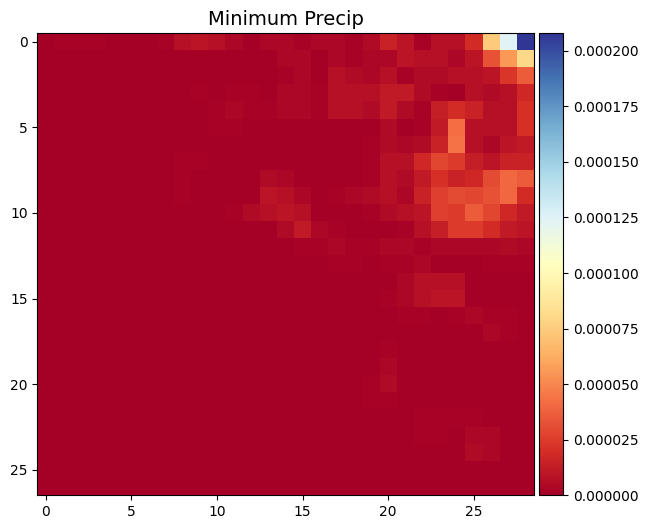

In [103]:
# Plot Minimums
fig, ax = plt.subplots(figsize=(10,6))
im1 = ax.imshow(min.to_array()[0], cmap='RdYlBu')
ax.set_title("Minimum Precip", fontsize=14)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

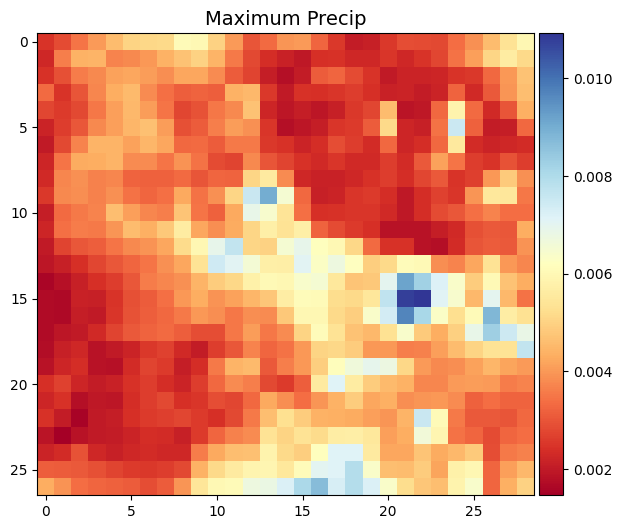

In [104]:
# Plot Maximums
fig, ax = plt.subplots(figsize=(10,6))
im1 = ax.imshow(max.to_array()[0], cmap='RdYlBu')
ax.set_title("Maximum Precip", fontsize=14)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

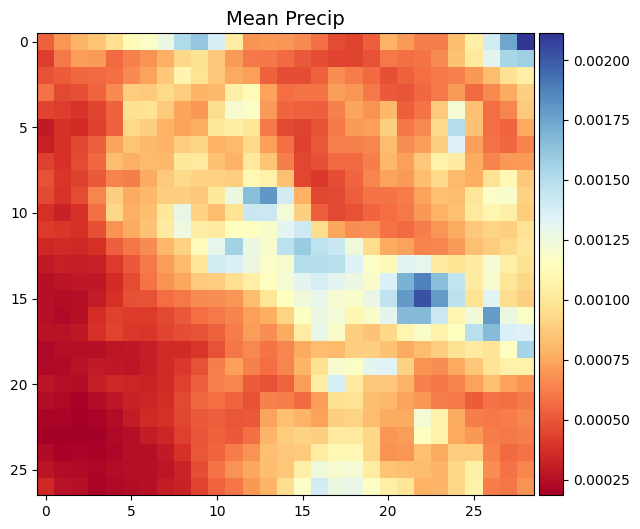

In [105]:
# Plot Means
fig, ax = plt.subplots(figsize=(10,6))
im1 = ax.imshow(mean.to_array()[0], cmap='RdYlBu')
ax.set_title("Mean Precip", fontsize=14)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

### Step 3: Read into Rasterio
The data don't have spatial dimensions in lat/lon terms, so creating a spatially-aware raster is necessary before analysis can be perfomed between buildings and precip

In [107]:
# Converts the NC file with precipitation data to A Raster
precip = no_expver['tp']
precip = precip.rio.set_spatial_dims(x_dim='latitude', y_dim='longitude')
reordered = precip.transpose('time', 'latitude', 'longitude')
reordered.rio.write_crs('epsg:32612', inplace=True)
reordered.rio.to_raster(os.path.join(ws, 'precip_raster.tiff'))

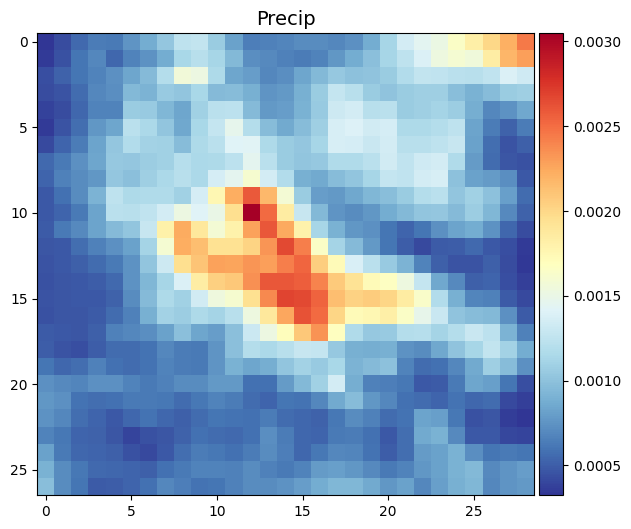

In [108]:
# Opens raster created in last cell, change file path to your own
precip_raster = rasterio.open(os.path.join(ws, 'precip_raster.tiff'))

#
precip_array = precip_raster.read(1)

fig, ax = plt.subplots(figsize=(10,6))
im1 = ax.imshow(precip_array, cmap='RdYlBu')

ax.set_title("Precip", fontsize=14)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')